<a href="https://colab.research.google.com/github/projet-ML/COVID/blob/master/codes/prediction_maroc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Reading and processing data 

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt



In [2]:
data = pd.read_csv(r'https://raw.githubusercontent.com/projet-ML/COVID/master/data/datasets_555986_1169004_COVID_Data_Basic.csv')
data.head()

,Unnamed: 0,Country,Date,Confirmed,Death,Recovered,newConfirmed,newDeath,newRecovered
0,1,Afghanistan,2019-12-31,0,0,0,0,0,0
1,2,Afghanistan,2020-01-01,0,0,0,0,0,0
2,3,Afghanistan,2020-01-02,0,0,0,0,0,0
3,4,Afghanistan,2020-01-03,0,0,0,0,0,0
4,5,Afghanistan,2020-01-04,0,0,0,0,0,0


In [0]:
def process_data(df):
    df.sort_values(by = 'Date', ascending = False)
    df['Days'] = range(1, len(df)+1)
    df['Infected'] = df['Confirmed']
    df['Recovered'] = (df['Recovered'].shift(1) + df['newRecovered']) *( df['Days'] != 1 )
    df['Deaths'] = df['Death']
    df['Deaths'] = (df['Deaths'].shift(1) + df['newDeath']) *( df['Days'] != 1 )
    df['Infected'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
    df['v_Infected'] = df['Infected'] - df['Infected'].shift(1) 
    df['v_R&D'] = df['Recovered'] + df['Deaths'] - df['Recovered'].shift(1) - df['Deaths'].shift(1)
     
    return df[['Days','Infected','Recovered','Deaths','v_Infected','v_R&D','Confirmed','Date']].fillna(0).set_index('Days')

In [0]:
def deriv(y, N, beta, gamma):
    
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [0]:
def compute_scenario(y0, N, beta, period,gamma = 1/14):
    S = []
    R = []
    I = []
    y = y0
    for day in period: 
        derive_y = deriv(y,N, beta, gamma)
        s,i,r = y[0]+ derive_y[0], y[1] + derive_y[1], y[2] + derive_y[2]
        S.append(s)
        I.append(i)
        R.append(r)
        y = s,i,r
    return S,I,R

total numbr of infected :984415
day of reaching the peak : 57


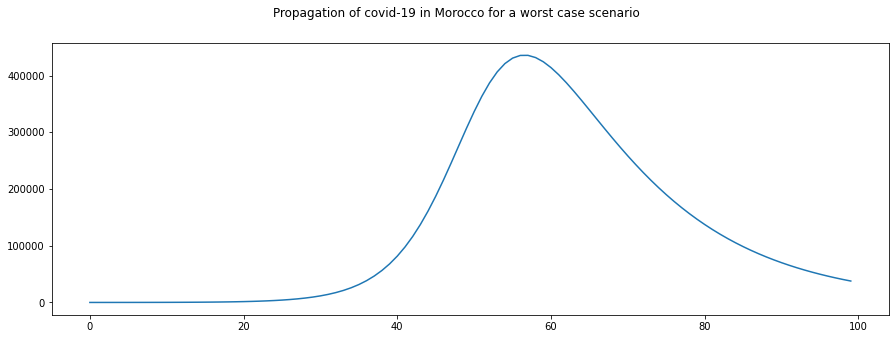

In [22]:
N= 10**6
y0 = N-20,20, 0
beta = 0.3
period = range(100)
S,I,R = compute_scenario(y0, N, beta, period)
fig = plt.figure(figsize=(15,5))
fig.suptitle('Propagation of covid-19 in Morocco for a worst case scenario', fontsize=12)
plt.plot(period, I)
n = int(I[-1] + R[-1])
print('total numbr of infected :'+ str(n))
print('day of reaching the peak : '  + str(I.index(max(I))))

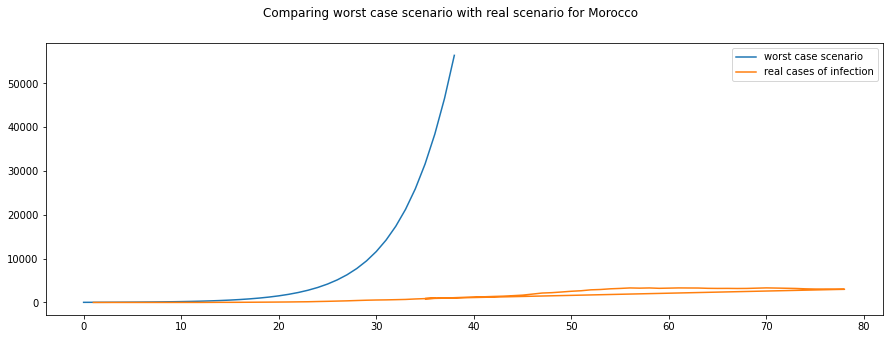

In [15]:
data_mor = data.query('Country=="Morocco" and Confirmed > 0 ').copy()
data_mor = process_data(data_mor)
new_data = pd.DataFrame({'Infected': [875,966],
                         'Recoverd' : [76,76],
                         'Deaths' : [70,71],
                         'v_Infected': [81,91],
                        ' v_R&D' : [21,1],
                         'Confirmed':[1021,1113],
                         'Date' : ['2020-04-05','2020-04-06'],
                         'beta' : [0.2,0.2]},
                         index = [35,36]
)
data_mor = data_mor.append(new_data, sort = True)
fig = plt.figure(figsize=(15,5))
fig.suptitle('Comparing worst case scenario with real scenario for Morocco', fontsize=12)
plt.plot(range(39), I[:39], label = 'worst case scenario')
plt.plot(data_mor.index, data_mor.Infected, label = 'real cases of infection')
plt.legend()

In [0]:
def compute_beta_i(variation,i, N,s,gamma = 1/14):
    if s ==0  or i ==0 : return 0
    return (variation + gamma * i) * N * (1/(s*i))

def compute_beta(df,N):
    df['beta'] = df.apply(lambda x : compute_beta_i(x['v_Infected'],x.Infected,N,N-x.Confirmed), axis =1)
    return df

def compute_beta_c( country, N,period = None):
    data_c = data.query('Country=="' + country + '"and Confirmed > 0' ).copy()
    data_c = process_data(data_c)
    if period :   
        period = list(period)
        period = range(period[0],min(period[-1], len(data_c)) )
        data_c = data_c[data_c.index.isin(period)]
    data_c = compute_beta(data_c, N)
    return data_c
   

In [0]:
def compute_scenario_for_country(country , N):
    scenario =compute_beta_c(country, N) 
    B = scenario.beta  
    I = []
    i = 0
    N= 10**6
    inf = 20
    y0 = N-inf, inf, 0
    C = []
    B_bis = B[35:]
    for beta in B:
        period = range(i,i+1)
        Y = compute_scenario(y0, N, beta, period,gamma = 1/15)
        i = i+1
        y0 = Y[0][-1], Y[1][-1], Y[2][-1]
        I = I + Y[1]
        C = C + Y[2]
    fig,axs = plt.subplots(1,2, figsize = (10,5))
    fig.suptitle('The case of :'+country , fontsize=12)
    axs[0].plot(range(len(I)), I, color = 'blue', label = 'Estimated evolution of the virus in Morocco')
    axs[0].plot(range(len(data_mor)), data_mor.Infected, 'x',color = 'r', label = 'real data')
    axs[1].plot(scenario.index, scenario.Infected, 'g', label= 'spread of Covid-19 in ' + country)
    fig.legend()
    print("total numbre of infected : " + str(C[-1]))
    print("day of peak :" + str(I.index(max(I)) + 1))

Estimating the spread of Corona in Morocco, through the data from various countries

The Case of China

total numbre of infected : 11694.188786120818
day of peak :50


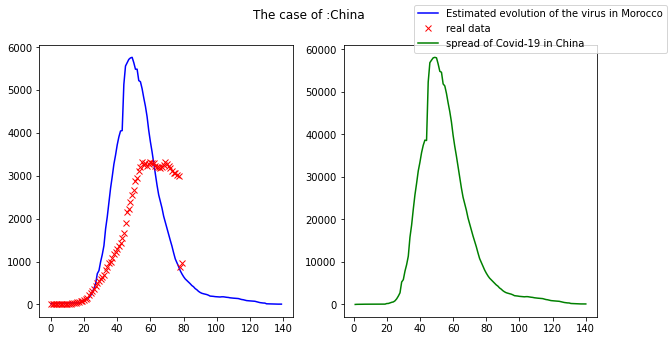

In [10]:
compute_scenario_for_country('China' , 10**9)

The case of south Korea

total numbre of infected : 16947.407395991133
day of peak :56


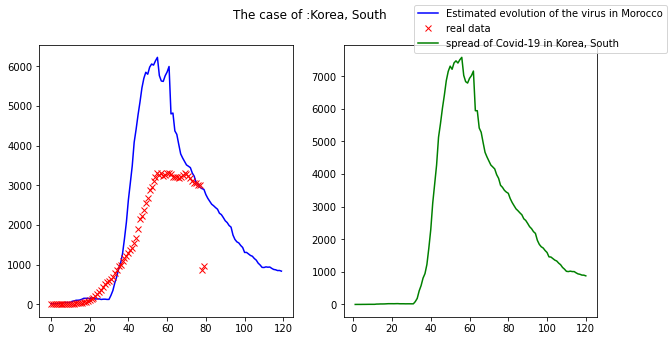

In [11]:
compute_scenario_for_country('Korea, South' , 10**6)

The Case of Italy

total numbre of infected : 167889.43361753426
day of peak :90


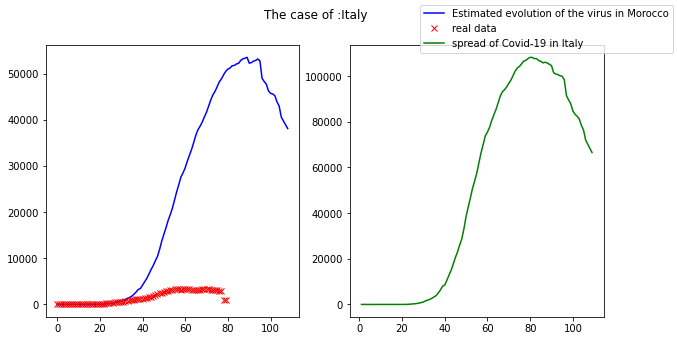

In [12]:
compute_scenario_for_country('Italy' , 10**6)

The case of Iran


total numbre of infected : 32956.49340206752
day of peak :47


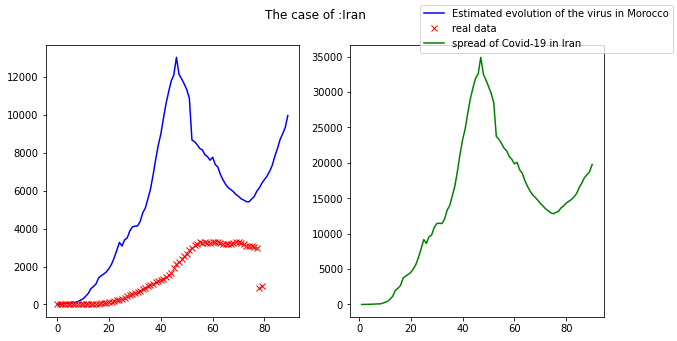

In [13]:
compute_scenario_for_country('Iran' , 10**6)

The case of Japan

total numbre of infected : 65649.69912678127
day of peak :111


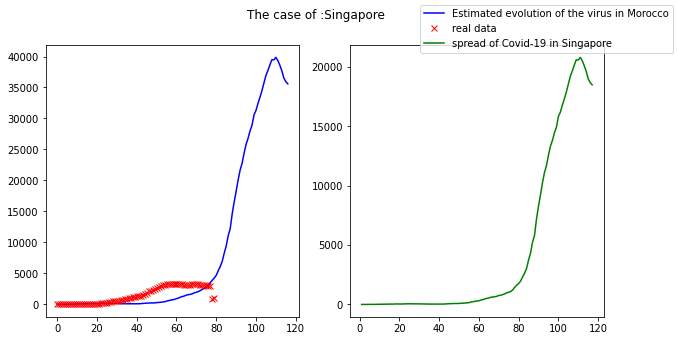

In [14]:
compute_scenario_for_country('Singapore' , 10**6)